# Introduction
This study explores the dataset made available for the competition<br>
**Hackathon 3.x - Predict customer worth for Happy Customer Bank**<br>
organised by _Analytics Vidhya_ in 2015.<br>

For more information follow the link below:<br>
https://discuss.analyticsvidhya.com/t/hackathon-3-x-predict-customer-worth-for-happy-customer-bank/3802

### **Problem** _(as described in challange)_

''Digital arms of banks today face challenges with lead conversion, they source leads through mediums like search, display, email campaigns and via affiliate partners. Here Happy Customer Bank faces same challenge of low conversion ratio. They have given a problem to identify the customers segments having higher conversion ratio for a specific loan product so that they can specifically target these customers, here they have provided a partial data set for salaried customers only from the last 3 months. They also capture basic details about customers like gender, DOB, existing EMI, employer Name, Loan Amount Required, Monthly Income, City, Interaction data and many others. Let’s look at the process at Happy Customer Bank.''

### **Goal**

Predict the probability of disbursal for test data set.

## Table of Contents

1. **[Data preprocessing](#first-bullet)**
2. **[Modelling](#second-bullet)**

### Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wikipedia
import re
from bs4 import BeautifulSoup
import seaborn as sns
import pickle

## Loading the data

In [3]:
FILE = r'Data/Train_nyOWmfK.csv'
data = pd.read_csv(FILE, encoding='latin1')
data.head()

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed
0,ID000002C20,Female,Delhi,20000,23-May-78,15-May-15,300000.0,5.0,0.0,CYBOSOL,...,NaN,NaN,NaN,N,Web-browser,G,S122,1,0,0
1,ID000004E40,Male,Mumbai,35000,07-Oct-85,04-May-15,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),...,13.25,NaN,6762.9,N,Web-browser,G,S122,3,0,0
2,ID000007H20,Male,Panchkula,22500,10-Oct-81,19-May-15,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,...,NaN,NaN,NaN,N,Web-browser,B,S143,1,0,0
3,ID000008I30,Male,Saharsa,35000,30-Nov-87,09-May-15,1000000.0,5.0,0.0,BIHAR GOVERNMENT,...,NaN,NaN,NaN,N,Web-browser,B,S143,3,0,0
4,ID000009J40,Male,Bengaluru,100000,17-Feb-84,20-May-15,500000.0,2.0,25000.0,GLOBAL EDGE SOFTWARE,...,NaN,NaN,NaN,N,Web-browser,B,S134,3,1,0


In [35]:
X, y = data.drop(["Disbursed"], axis=1), data.Disbursed

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=20, stratify=y)

# 1. Data preprocessing <a class="anchor" id="first-bullet"></a>

## Creating dictionaries

### Wikipedia scraping

In [7]:
def wiki_table_scraper(title, table_num=0, header=True):
    wikipedia.set_lang("en")
    page = wikipedia.page(title=title).html()
    soup = BeautifulSoup(page, 'html')
    table = soup.find_all('table', {'class':"wikitable sortable"})[table_num]
    head = False
    if header:
        trs = table.find_all('tr')[1:]
        head = [line.text.strip() for line in table.find_all('tr')[0].find_all('th')]
    else:
        trs = table.find_all('tr')
    
    table_list = [[n.text.strip() for n in line.find_all('td')] for line in trs]
    result = pd.DataFrame(data=table_list, columns=head)
    return result

#### Assigning state to particular city
**1st approach:** _Retrieving information from the Indian population table_

In [8]:
def match_state():
    city_state = wiki_table_scraper('List_of_cities_in_India_by_population')
    city_state.City = city_state.City.apply(lambda x: re.search(r'[\w]+', x).group())
    city_state.iloc[:,4] = city_state.iloc[:,4].apply(lambda x: re.search(r'[\w ]+', x).group())
    state_dict = city_state.set_index(city_state.iloc[:,1]).iloc[:,4].to_dict()
    return state_dict

**2nd approach:** _Search for specific queries_  >>>  _(Filling in the missing information for cities not included in the table.)_

In [9]:
def unmatched(df, match_dict, key):
    non_match = df[~df[key].isin(match_dict.keys())][key].value_counts().index
    return non_match

In [10]:
def match_state_complex(state_names, unmatched, a_sugg=False):    
    matching = {}
    for name in unmatched:
        try:
            page_key = wikipedia.search(f'{name} india')[0]
            page_summary = wikipedia.page(page_key, auto_suggest=a_sugg).summary
            matching[name] = page_summary
        except:
            pass
    match_df = pd.DataFrame.from_dict(matching, orient='index')
    match_df.index
    
    matching_states = {}
    for ix in match_df.index:
        try:
            for word in (match_df.loc[ix, 0]).split():
                if word in state_names:
                    correct_state = word
                    break
            matching_states[ix] = correct_state
        except:
            pass
    return matching_states

#### Assigning GDPs to states

In [11]:
def match_state_GDP():
    gdpS = wiki_table_scraper('List_of_Indian_states_and_union_territories_by_GDP')
    gdpS.iloc[:,2] = gdpS.iloc[:,2].apply(lambda x: re.search(r'\d+.\d+ la', x).group()[:-3]).map(float)
    state_to_gdp = gdpS.set_index(gdpS.iloc[:,1]).iloc[:,2].to_dict()
    return state_to_gdp

#### Assigning population count to cities

In [12]:
def match_population():
    city_table = wiki_table_scraper('List_of_cities_in_India_by_population')
    city_table.City = city_table.City.apply(lambda x: re.search(r'[\w]+', x).group())
    city_table.iloc[:,2] = city_table.iloc[:,2].apply(lambda x: x.replace(',','')).map(int)
    city_pop_dict = city_table.set_index(city_table.iloc[:,1]).iloc[:,2].to_dict()
    return city_pop_dict

In [13]:
def create_dictionaries(dataframe):
#     city_to_state = match_state()
#     states = set(city_to_state.values()) # set of India's states for further use

#     non_matched = unmatched(dataframe, city_to_state, 'City')
#     city_to_state.update(match_state_complex(states, non_matched))
    
    #------------------------------------------------
    # with open('city_to_state.pkl', 'wb') as f:
    #         pickle.dump(city_to_state, f)

    with open('city_to_state.pkl', 'rb') as f:
            city_to_state = pickle.load(f)
    #------------------------------------------------
    states = set(city_to_state.values())
    
    non_matched = unmatched(dataframe, city_to_state, 'City')
    city_to_state.update(match_state_complex(states, non_matched, a_sugg=True))

    states_not_matched = unmatched(dataframe, city_to_state, 'City')
    
    GDP_dict = match_state_GDP()
    city_population = match_population()
    
    # Creating City Rank with first 20 cities sorted by most frequent occurrence in the data
    city_rank_keys = dataframe.City.value_counts()[:20].keys()
    
    # Creating Employer Rank with first 15 Employers sorted by most frequent occurrence in the data
    employer_rank_keys = dataframe.Employer_Name.value_counts()[:15].keys()
    
    return city_to_state, GDP_dict, city_population, city_rank_keys, employer_rank_keys, states_not_matched

#### Monthly Income
Cutting part of the outliers with substitution to the maximum value _100 000_ (this value is still over upper IQR bound)

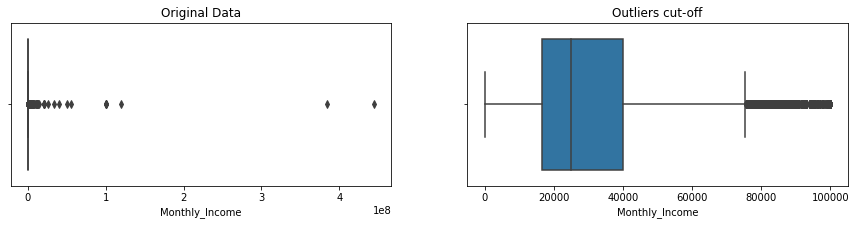

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(15,3))

sns.boxplot(x=X_train.Monthly_Income, ax=axs[0])
axs[0].title.set_text("Original Data")
sns.boxplot(x=X_train.Monthly_Income.where(X_train.Monthly_Income < 100000, other=100000), ax=axs[1])
axs[1].title.set_text("Outliers cut-off")

plt.show()

In [15]:
# dictionaries = create_dictionaries(X_train)

# with open('dictionaries.pkl', 'wb') as f:
#     pickle.dump(dictionaries, f)

with open('dictionaries.pkl', 'rb') as f:
    dictionaries = pickle.load(f)
        
to_state, GDPs, population, city_rank, employer_rank_keys, states_not_matched = dictionaries

There are a few cities with no state assigned - for the purpose of simplicity they will be ignored in this study:

In [16]:
print(X_train[X_train.City.isin(states_not_matched)].City.value_counts())
print('\nMissing', X_train[X_train.City.isin(states_not_matched)].City.count(), 'values.')

AHMEDB                  9
Janigir - Champa        7
Pontashaib              5
Proddattur              5
Kamrup Metropolitian    3
Banaskhantha            3
DHANGARDHA              3
SURENDERNAGAR           3
SOMNATH JUNAGADHA       1
Surendra Nagar          1
Chinnamiram             1
Name: City, dtype: int64

Missing 41 values.


In [17]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attribute_names]

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

In [19]:
class CatDictionaries(BaseEstimator, TransformerMixin):
    def __init__(self, state, city_rank, emp_rank):
        self.state = state
        self.city_rank = city_rank
        self.emp_rank = emp_rank
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        df = pd.DataFrame(columns=['State', 'City_rank', 'Employer_rank'])
        df.State = X.City.map(self.state)
        df.City_rank = X.City.where(X.City.isin(self.city_rank), other='other')
        df.Employer_rank = X.Employer_Name.where(X.Employer_Name.isin(self.emp_rank), other='other')
        return df
    
class NumDictionaries(BaseEstimator, TransformerMixin):
    def __init__(self, state, gpd, population):
        self.state = state
        self.gpd = gpd
        self.population = population
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        df = pd.DataFrame(columns=['StateGDP','City_population'])
        df.StateGDP = X.City.map(self.state).map(self.gpd).map(float)
        df.City_population = X.City.map(self.population)
        return df

#### Dates processing

In [20]:
class DateFix(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        df = pd.DataFrame(columns=['Age_at_lead'])
        df.Age_at_lead = pd.to_datetime(X['Lead_Creation_Date'], format='%d-%b-%y').dt.year - pd.to_datetime(X['DOB'], format='%d-%b-%y').dt.year
        df.Age_at_lead = df['Age_at_lead'].where(df['Age_at_lead'] > 0, df['Age_at_lead'] + 100)
        df.Age_at_lead = np.log(1+df.Age_at_lead)
        return df

In [21]:
class Money(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.imputer = None
    def fit(self, X, y=None):
        for_impute = X[['Monthly_Income', 'Loan_Amount_Submitted', 'Loan_Tenure_Submitted', 'Interest_Rate', 'Processing_Fee']]
        imputer = KNNImputer(n_neighbors=2)
        self.imputer = imputer.fit(for_impute.dropna(how='any').sample(n=500))
        return self
    def transform(self, X, y=None):
        df = pd.DataFrame(columns=['Monthly_Income', 'Loan_Amount_Submitted', 'Loan_Tenure_Submitted', 'Interest_Rate',
                                   'Processing_Fee', 'EMI_sub_calc', 'EMI_Income_tot_ratio', 'EMI_sub_Income_ratio']) #, 'Loan_Amount_Applied', 'Loan_Tenure_Applied'])
        df.Monthly_Income = X.Monthly_Income.where(X.Monthly_Income < 100000, other=100000)
        for_impute = X[['Monthly_Income', 'Loan_Amount_Submitted', 'Loan_Tenure_Submitted', 'Interest_Rate', 'Processing_Fee']]
        imputed = self.imputer.transform(for_impute)
        df.Loan_Amount_Submitted = pd.DataFrame(imputed, index=for_impute.index)[1]
        df.Loan_Tenure_Submitted = pd.DataFrame(imputed, index=for_impute.index)[2]
        df.Interest_Rate = pd.DataFrame(imputed, index=for_impute.index)[3]
        df.Processing_Fee = pd.DataFrame(imputed, index=for_impute.index)[4]
       
        # creating additional columns: EMI calculated and EMI/Income ratios
        EMI_P = df.Loan_Amount_Submitted
        EMI_R = df.Interest_Rate/12/100
        EMI_N = df.Loan_Tenure_Submitted*12

        df.EMI_sub_calc = (EMI_P * EMI_R * (1 + EMI_R)**EMI_N) / ((1 + EMI_R)**EMI_N - 1)
        df.EMI_Income_tot_ratio = (X.Existing_EMI + df.EMI_sub_calc) / X.Monthly_Income
        df.EMI_sub_Income_ratio = df.EMI_sub_calc / X.Monthly_Income
        
        df.EMI_sub_calc = np.log(1+df.EMI_sub_calc)
        df.EMI_Income_tot_ratio = df.EMI_Income_tot_ratio.where(df.EMI_Income_tot_ratio < 1, other=1)
        df.EMI_Income_tot_ratio = np.log(1+df.EMI_Income_tot_ratio)
        df.EMI_sub_Income_ratio = df.EMI_sub_Income_ratio.where(df.EMI_sub_Income_ratio < 1, other=1)
#         df.EMI_sub_Income_ratio = np.log(1+df.EMI_sub_Income_ratio)
        df.Loan_Amount_Submitted = np.log(1+df.Loan_Amount_Submitted)
        df.Processing_Fee = np.log(1+df.Processing_Fee)
        
#         df.Loan_Amount_Applied = np.log(1+X.Loan_Amount_Applied)
#         df.Loan_Tenure_Applied = X.Loan_Tenure_Applied
        
        return df

In [43]:
cat_dict_pipeline = Pipeline([
        ("selector", DataFrameSelector(['City','Employer_Name'])),
        ("dictionary", CatDictionaries(to_state, city_rank, employer_rank_keys)),
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False, handle_unknown='ignore'))
    ])
num_dict_pipeline = Pipeline([
        ("selector", DataFrameSelector(['City'])),
        ("dictionary", NumDictionaries(to_state, GDPs, population)),
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", MinMaxScaler())
    ])
dates_pipeline = Pipeline([
        ("selector", DataFrameSelector(['Lead_Creation_Date', 'DOB'])),
        ("date_manager", DateFix()),
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", MinMaxScaler())
    ])
money_pipeline = Pipeline([
        ("selector", DataFrameSelector(['Loan_Amount_Applied', 'Loan_Tenure_Applied', 'Monthly_Income', 'Loan_Amount_Submitted',
                                        'Loan_Tenure_Submitted', 'Interest_Rate', 'Processing_Fee', 'Existing_EMI'])),
        ("date_manager", Money()),
        ("scaler", MinMaxScaler())
    ])

cat_pipeline = Pipeline([
        ("selector", DataFrameSelector(['Gender', 'Var1', 'Var2', 'Source', 'Var4'])),
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False, handle_unknown='ignore'))
    ])
num_pipeline = Pipeline([
        ("selector", DataFrameSelector(['Var5'])),
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", MinMaxScaler())
    ])

In [44]:
from sklearn.pipeline import FeatureUnion

preprocess_pipeline = FeatureUnion(transformer_list=[
        ("category_dict", cat_dict_pipeline),
        ("numerical_dict", num_dict_pipeline),
        ("dates", dates_pipeline),
        ("money", money_pipeline),
        ("categorical", cat_pipeline),
        ("numerical", num_pipeline),
    ])

# 2. Modelling <a class="anchor" id="second-bullet"></a>

In [24]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import VarianceThreshold

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.metrics import roc_auc_score
import scipy.stats as ss

from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

from collections import Counter

## Evaluation Cirteria
Evaluation metrics of this challenge was ROC_AUC.

In [25]:
def model_scoring(model,y_tr, X_tr ,y_te, X_te):
    y_pred_train = model.predict_proba(X_tr)[:,1]
    train_score = roc_auc_score(y_tr, y_pred_train)
    y_pred_test = model.predict_proba(X_te)[:,1]
    test_score = roc_auc_score(y_te, y_pred_test)
    print(f'Train ROC_AUC Score: {train_score.round(4)}')
    print(f'Test ROC_AUC Score: {test_score.round(4)}')

## Imbalance Check

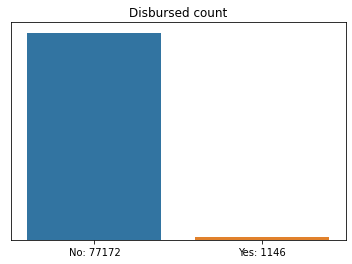

In [26]:

sns.barplot(x=[0,1], y=[y_train.size - y_train.sum(), y_train.sum()])
plt.xticks([0,1], labels=[f'No: {y_train.size - y_train.sum()}', f'Yes: {y_train.sum()}'])
plt.yticks([])
plt.title('Disbursed count')
plt.show()

**Significant imbalance in data will have to be adressed in modeling phase.**<br>
Stratified K-Folds cross-validator will be used to partially deal with this issue.

In [27]:
skf = StratifiedKFold(n_splits=10)

In [102]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier

### TODO
- hyperparam optimization
- best model selection

In [487]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('var_cut', VarianceThreshold()),
    ('classifier', LogisticRegression(penalty='l1', solver='saga', C=.1))
])
pipe.fit(X_train, y_train)
model_scoring(pipe, y_train, X_train, y_test, X_test)

Train ROC_AUC Score: 0.8285
Test ROC_AUC Score: 0.8418


In [57]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', DecisionTreeClassifier(min_samples_leaf=40, max_depth=15))
])
pipe.fit(X_train, y_train)
model_scoring(pipe, y_train, X_train, y_test, X_test)

Train ROC_AUC Score: 0.934
Test ROC_AUC Score: 0.7591


In [98]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('var_cut', VarianceThreshold()),
    ('classifier', BaggingClassifier(n_estimators=40, max_samples=.4))
])
pipe.fit(X_train, y_train)
model_scoring(pipe, y_train, X_train, y_test, X_test)

Train ROC_AUC Score: 0.9996
Test ROC_AUC Score: 0.7466


In [100]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('var_cut', VarianceThreshold()),
    ('classifier', AdaBoostClassifier(n_estimators=150, learning_rate=.4))
])
pipe.fit(X_train, y_train)
model_scoring(pipe, y_train, X_train, y_test, X_test)

Train ROC_AUC Score: 0.8627
Test ROC_AUC Score: 0.8448


In [105]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('var_cut', VarianceThreshold()),
    ('classifier', GradientBoostingClassifier(n_estimators=200,learning_rate=.07))
])
pipe.fit(X_train, y_train)
model_scoring(pipe, y_train, X_train, y_test, X_test)

Train ROC_AUC Score: 0.8847
Test ROC_AUC Score: 0.8586


## RFC model
First try - _default_ **RFC**:

In [488]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', RandomForestClassifier())
])
pipe.fit(X_train, y_train)
model_scoring(pipe, y_train, X_train, y_test, X_test)

Train ROC_AUC Score: 1.0
Test ROC_AUC Score: 0.7824


As expected, default model is overfitting the data.<br>
Limmited samples in leaves should do the trick (as below).

In [48]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', RandomForestClassifier(min_samples_leaf=50))
])
pipe.fit(X_train, y_train)
model_scoring(pipe, y_train, X_train, y_test, X_test)

Train ROC_AUC Score: 0.9195
Test ROC_AUC Score: 0.8587


### Searching for optimal parameter combination (RFC)

In [41]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', RandomForestClassifier())
])
param_grid = {'classifier__n_estimators': [100,130,150,200,250],
              'classifier__min_samples_leaf': [5,10,15,20,30,40,50],
              'classifier__max_depth': [2,3,4,6,8,None]
              }
grid = GridSearchCV(pipe, param_grid,
                    cv=skf,
                    scoring='roc_auc',
                    n_jobs=-1)

grid.fit(X_train, y_train)
grid.best_params_

c:\users\antos\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


{'classifier__min_samples_leaf': 10, 'classifier__n_estimators': 100}

In [42]:
model_scoring(grid.best_estimator_, y_train, X_train, y_test, X_test)

Train ROC_AUC Score: 0.9854
Test ROC_AUC Score: 0.8646


In [11]:
with open('grid_RFC.pkl', 'rb') as f:
    grid = pickle.load(f)

### Feature selection

In [91]:
grid.best_estimator_['preprocessing'].transformer_list[0][1]['cat_encoder'].get_feature_names()
# .transformers_[1][1]['onehot']\
#                    .get_feature_names(categorical_features)

array(['x0_Andhra Pradesh', 'x0_Assam', 'x0_Bihar', 'x0_Chandigarh',
       'x0_Chhattisgarh', 'x0_Delhi', 'x0_Gujarat', 'x0_Haryana',
       'x0_Himachal Pradesh', 'x0_Jammu and Kashmir', 'x0_Jharkhand',
       'x0_Karnataka', 'x0_Kerala', 'x0_Madhya Pradesh', 'x0_Maharashtra',
       'x0_Manipur', 'x0_Mizoram', 'x0_Odisha', 'x0_Puducherry',
       'x0_Punjab', 'x0_Rajasthan', 'x0_Sikkim', 'x0_Tamil Nadu',
       'x0_Telangana', 'x0_Tripura', 'x0_Uttar Pradesh', 'x0_Uttarakhand',
       'x0_West Bengal', 'x1_Ahmedabad', 'x1_Bengaluru', 'x1_Chandigarh',
       'x1_Chennai', 'x1_Coimbatore', 'x1_Delhi', 'x1_Ghaziabad',
       'x1_Gurgaon', 'x1_Hyderabad', 'x1_Indore', 'x1_Jaipur',
       'x1_Kolkata', 'x1_Lucknow', 'x1_Mumbai', 'x1_Nagpur', 'x1_Pune',
       'x1_Surat', 'x1_Thane', 'x1_Vadodara', 'x1_Visakhapatnam',
       'x1_other', 'x2_0', 'x2_ACCENTURE SERVICES PVT LTD',
       'x2_COGNIZANT TECHNOLOGY SOLUTIONS INDIA PVT LTD', 'x2_GENPACT',
       'x2_GOOGLE', 'x2_HCL TECHNOLOGIES 

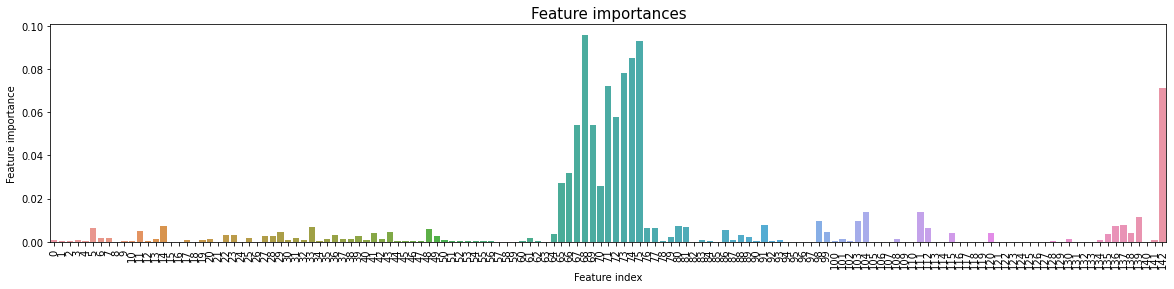

In [46]:
f_imp = grid.best_estimator_['classifier'].feature_importances_
plt.figure(figsize=(20,4))
sns.barplot(x=[n for n,_ in enumerate(f_imp)], y=f_imp)
plt.xticks(rotation=90)
plt.xlabel('Feature index')
plt.ylabel('Feature importance')
plt.title('Feature importances', fontdict={'fontsize': 15})
plt.show()

## XGBoost model

With default settings this model performes quite well - still overfitting the data.

In [59]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', XGBClassifier(objective='binary:logistic', use_label_encoder=False))
])
pipe.fit(X_train, y_train)
model_scoring(pipe, y_train, X_train, y_test, X_test)

[22:22:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train ROC_AUC Score: 0.9761
Test ROC_AUC Score: 0.8467


With _balancing of positive and negative weights_ model seems to overfit the data, but for more complex settings it will actually enhence the performance.

In [60]:
counter = Counter(y)
scale_weight = np.round(counter[0]/counter[1], 2)
print(scale_weight)

67.36


In [61]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', XGBClassifier(objective='binary:logistic', scale_pos_weight=scale_weight, use_label_encoder=False))
])
pipe.fit(X_train, y_train)
model_scoring(pipe, y_train, X_train, y_test, X_test)

[22:23:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train ROC_AUC Score: 0.9823
Test ROC_AUC Score: 0.8363


**First 'blind' shot of parameters:**

In [63]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('var_cut', VarianceThreshold()),
    ('classifier', XGBClassifier(n_estimators=150, learning_rate=0.03, max_depth=7,
                      use_label_encoder=False,
                      objective='binary:logistic'))
])
pipe.fit(X_train, y_train)
model_scoring(pipe, y_train, X_train, y_test, X_test)

[22:24:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train ROC_AUC Score: 0.9138
Test ROC_AUC Score: 0.8561


The same model, but with scale weights:

In [64]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('var_cut', VarianceThreshold()),
    ('classifier', XGBClassifier(n_estimators=150, learning_rate=0.03, max_depth=7, scale_pos_weight=scale_weight,
                      use_label_encoder=False,
                      objective='binary:logistic'))
])
pipe.fit(X_train, y_train)
model_scoring(pipe, y_train, X_train, y_test, X_test)

[22:25:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train ROC_AUC Score: 0.9264
Test ROC_AUC Score: 0.8586


Manual correction of parameters:

In [66]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('var_cut', VarianceThreshold()),
    ('classifier', XGBClassifier(n_estimators=180, learning_rate=0.026, max_depth=8, scale_pos_weight=scale_weight,
                      use_label_encoder=False,
                      objective='binary:logistic'))
])
pipe.fit(X_train, y_train)
model_scoring(pipe, y_train, X_train, y_test, X_test)

[22:27:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train ROC_AUC Score: 0.9482
Test ROC_AUC Score: 0.8631


### Searching for optimal parameter combination (XGBoost)

In [104]:
model = XGBClassifier(objective='binary:logistic', scale_pos_weight=scale_weight)
param_grid = {"n_estimators": [180], 
              "learning_rate": ss.uniform(0.01, 0.028),
              "max_depth": ss.randint(7, 9),
              "gamma": ss.uniform(0, 0.05)}

optimizer = RandomizedSearchCV(model, param_grid, 
                               n_iter=100, 
                               cv=skf, 
                               n_jobs=-1,
                               scoring='roc_auc')
optimizer.fit(X_train, y_train)

c:\users\antos\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:26:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=None),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_wei...
                                           verbosity=None),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F7BE456C10>,
                                        '

In [105]:
optimizer.best_params_

{'gamma': 0.04966376744888,
 'learning_rate': 0.03043095178371477,
 'max_depth': 7,
 'n_estimators': 180}

Optimized parameters turn out to perform similar to 'blind shot'.<br>

In [238]:
gamma_opt = []
learning_rate_opt = []
max_depth_opt = []
for n in optimizer.cv_results_['params']:
    gamma_opt.append(n['gamma'])
    learning_rate_opt.append(n['learning_rate'])
    max_depth_opt.append(n['max_depth'])

depth_7 = np.where(np.array(max_depth_opt)==7)
depth_8 = np.where(np.array(max_depth_opt)==8)

gamma_opt = np.array(gamma_opt)
learning_rate_opt = np.array(learning_rate_opt)
score_opt = optimizer.cv_results_['mean_test_score']

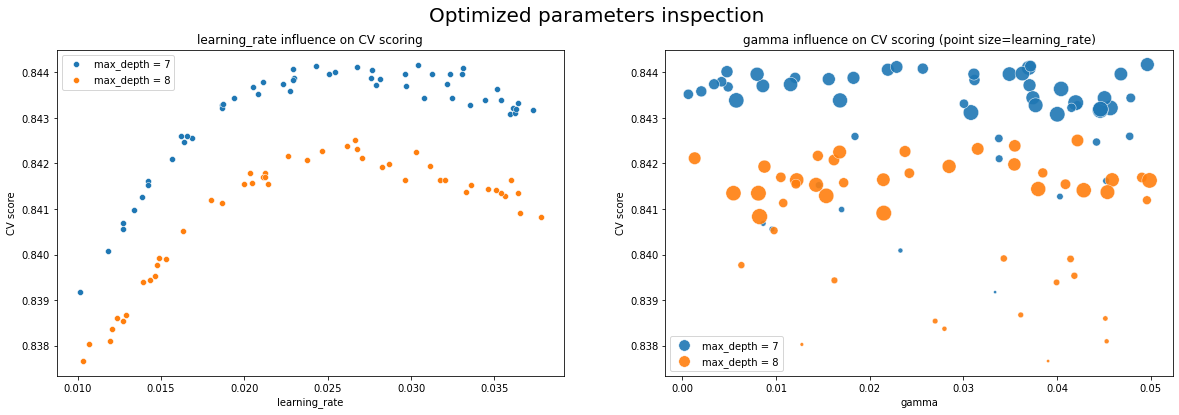

In [250]:
fig, axs = plt.subplots(1, 2, figsize=(20,6))

axs[0] = sns.scatterplot(x=learning_rate_opt[depth_7], y=score_opt[depth_7], ax=axs[0])
axs[0] = sns.scatterplot(x=learning_rate_opt[depth_8], y=score_opt[depth_8], ax=axs[0])
axs[0].legend(['max_depth = 7', 'max_depth = 8'])
axs[0].set_xlabel('learning_rate')
axs[0].set_ylabel('CV score')
axs[0].title.set_text('learning_rate influence on CV scoring')

axs[1] = sns.scatterplot(x=gamma_opt[depth_7], y=score_opt[depth_7], size=learning_rate_opt[depth_7], sizes=(10, 250), alpha=.9, ax=axs[1], legend=False)
axs[1] = sns.scatterplot(x=gamma_opt[depth_8], y=score_opt[depth_8], size=learning_rate_opt[depth_8], sizes=(10, 250), alpha=.9, ax=axs[1], legend=False)
axs[1].legend(['max_depth = 7', 'max_depth = 8'])
axs[1].set_xlabel('gamma')
axs[1].set_ylabel('CV score')
axs[1].title.set_text('gamma influence on CV scoring (point size=learning_rate)')

fig.suptitle('Optimized parameters inspection', fontsize=20) 
plt.show()

Unlike gamma's, learning_rate parameter's influence on performence is very noticable.

# Conclusions
RFC performs really good on this dataset and so do XGBoost. Further optimization of parameters woud be a good path for even better performance, especially for XGBoost. Because of multitude of hyperparameters, another search strategy could be utilized for greater efficiency (possibly Hyperopt optimization would satisfy the needs).

Both models score above 86% roc_auc for test set (for reproducibility with constant split seed).